In [1]:
import pandas as pd
from pathlib import Path
import math
import matplotlib.pyplot as plt

In [2]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'GPU' or 'CPU' and make it uppercase
    _, implementation, n_docs, n_queries, iteration = parts
    implementation = implementation.upper()
    iteration = int(iteration)
    n_docs = int(n_docs)
    n_queries = int(n_queries)
    
    # Read execution time from file
    execution_time = None
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    if execution_time is None:
        print(f"Failed to parse execution time in {file_path}")
        return None
    return dict(implementation=implementation, n_docs=n_docs, n_queries=n_queries, execution_time=execution_time, iteration=iteration)

In [3]:
# Collect all txt files matching the pattern
files = Path('../results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [item for item in [extract_information(file) for file in files] if item]
df = pd.DataFrame.from_records(data)

print(df)

Failed to parse execution time in ../results/out-cpu-1000-10000-3.txt
Failed to parse execution time in ../results/out-cpu-1000-10000-1.txt
Failed to parse execution time in ../results/out-cpu-10000-10000-3.txt
Failed to parse execution time in ../results/out-cpu-10000-1000-3.txt
Failed to parse execution time in ../results/out-cpu-10000-10000-2.txt
Failed to parse execution time in ../results/out-cpu-10000-1000-2.txt
Failed to parse execution time in ../results/out-cpu-10000-1000-1.txt
Failed to parse execution time in ../results/out-cpu-1000-10000-2.txt
Failed to parse execution time in ../results/out-cpu-10000-10000-1.txt
   implementation  n_docs  n_queries  execution_time  iteration
0             CPU    1000       1000        5423.259          1
1             GPU     100        100         232.990          3
2             CPU   10000         10         555.501          2
3             GPU     100      10000         248.576          3
4             GPU      10       1000         22

In [4]:
df.sort_values(by=['implementation', 'n_docs', 'n_queries'])

,implementation,n_docs,n_queries,execution_time,iteration
19,CPU,10,10,0.962,2
58,CPU,10,10,1.269,1
59,CPU,10,10,1.234,3
33,CPU,10,100,10.070,2
42,CPU,10,100,5.647,1
...,...,...,...,...,...
16,GPU,10000,1000,30532.986,3
27,GPU,10000,1000,30504.214,1
10,GPU,10000,10000,232.220,1
13,GPU,10000,10000,230.428,3


In [5]:
agg_df = (
    df[['implementation', 'n_docs', 'n_queries', 'execution_time']]
        .groupby(['implementation', 'n_docs', 'n_queries'])
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df.head()

,implementation,n_docs,n_queries,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,10,1.155000,0.962,1.269,0.168057
1,CPU,10,100,7.034333,5.386,10.070,2.632201
2,CPU,10,1000,63.530667,62.566,64.918,1.231650
3,CPU,10,10000,534.524333,533.519,535.429,0.958971
4,CPU,100,10,10.071667,9.363,10.523,0.621342


In [6]:
cpu_mask = agg_df['implementation']=='CPU'
gpu_mask = agg_df['implementation']=='GPU'

## Execution time vs number of docs

In [7]:
def plot_execution_time_per_n_docs(agg_df, n_queries: int):
    q_mask = agg_df['n_queries']==n_queries

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(agg_df.loc[cpu_mask & q_mask, 'n_docs'], agg_df.loc[cpu_mask & q_mask, 'mean_execution_time'], label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask & q_mask, 'n_docs'], agg_df.loc[gpu_mask & q_mask, 'mean_execution_time'], label='GPU', marker='.', s=100, c='blue')

    ax.set_title(f'Execution time vs number of documents when number of queries={n_queries}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of documents')
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xticks(agg_df.loc[gpu_mask & q_mask, 'n_docs'], labels=[f"$10^{{{int(math.log(n_docs, 10))}}}$" for n_docs in agg_df.loc[gpu_mask & q_mask, 'n_docs'].values])
    ax.legend()

    return fig

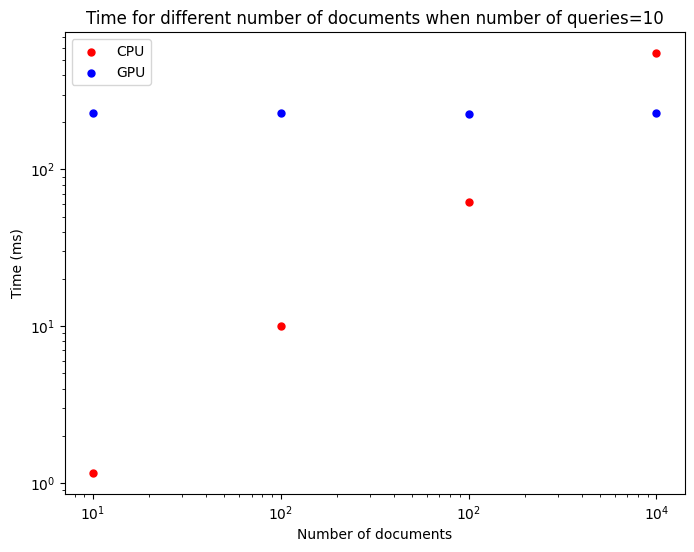

In [8]:
plot_execution_time_per_n_docs(agg_df, 10);

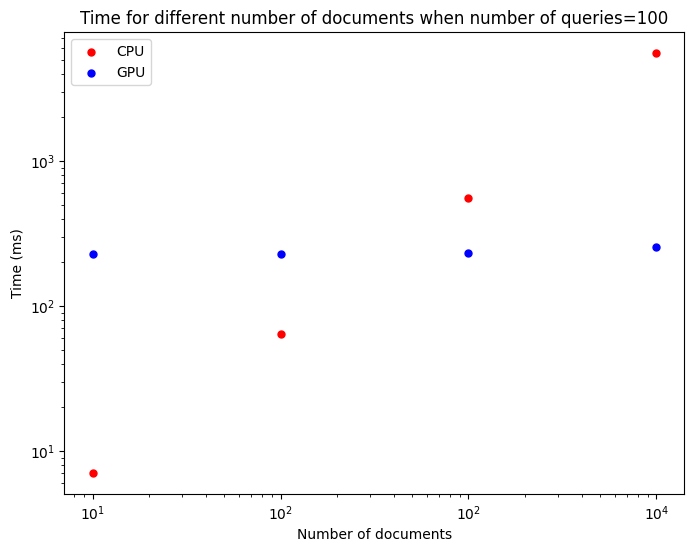

In [9]:
plot_execution_time_per_n_docs(agg_df, 100);

## Execution time vs number of queries

In [10]:
agg_df

,implementation,n_docs,n_queries,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,10,1.155000,0.962,1.269,0.168057
1,CPU,10,100,7.034333,5.386,10.070,2.632201
2,CPU,10,1000,63.530667,62.566,64.918,1.231650
3,CPU,10,10000,534.524333,533.519,535.429,0.958971
4,CPU,100,10,10.071667,9.363,10.523,0.621342
5,CPU,100,100,63.720333,55.320,67.921,7.274902
6,CPU,100,1000,554.292667,549.452,561.259,6.183863
7,CPU,100,10000,5437.414667,5369.895,5490.244,61.504674
8,CPU,1000,10,61.654667,55.280,65.006,5.523059
9,CPU,1000,100,556.220667,552.875,560.963,4.221012


In [11]:
def plot_execution_time_per_n_queries(agg_df, n_docs: int):
    d_mask = agg_df['n_docs']==n_docs

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(agg_df.loc[cpu_mask & d_mask, 'n_queries'], agg_df.loc[cpu_mask & d_mask, 'mean_execution_time'], label='CPU', marker='.', s=100, c='red')

    # print(len(agg_df.loc[cpu_mask & d_mask, 'n_queries']))
    ax.scatter(agg_df.loc[gpu_mask & d_mask, 'n_queries'], agg_df.loc[gpu_mask & d_mask, 'mean_execution_time'], label='GPU', marker='.', s=100, c='blue')

    ax.set_title(f'Execution time vs number of queries when number of docs={n_docs}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of queries')
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xticks(agg_df.loc[cpu_mask & d_mask, 'n_queries'], labels=[f"$10^{{{int(math.log(n_docs, 10))}}}$" for n_docs in agg_df.loc[cpu_mask & d_mask, 'n_queries'].values])
    ax.legend()

    return fig

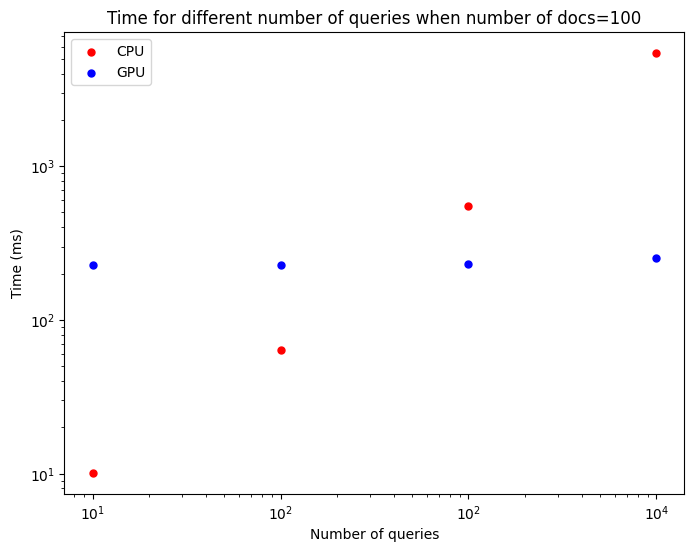

In [12]:
plot_execution_time_per_n_queries(agg_df, 100);

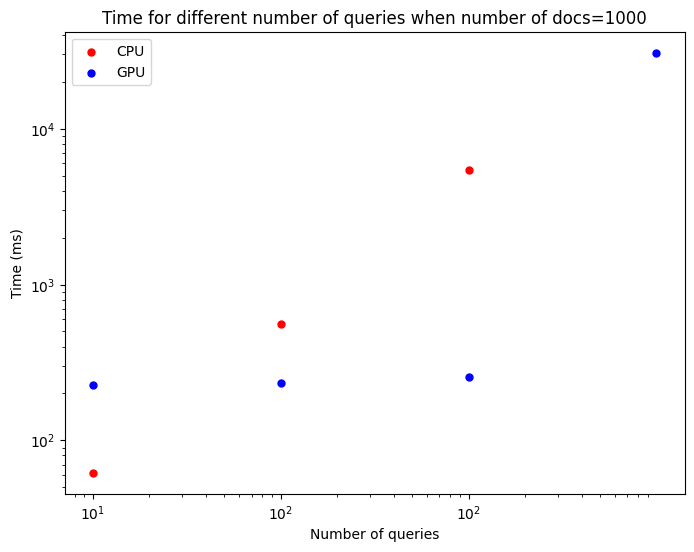

In [13]:
plot_execution_time_per_n_queries(agg_df, 1000);